In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat, lpad, col, year, month, lit
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from datetime import date


In [2]:
# Gdown used in order to get the file from google drive.
!pip install gdown

In [3]:
import gdown

In [4]:
# Get the file calendar, customer_flight_activity, customer_loyal_history.
!gdown https://drive.google.com/uc?id=1Ahz9hadZC5L1gE3bt7b-1G0LZH49t1Zb
!gdown https://drive.google.com/uc?id=1830nV_EOTITx7YeDjMu_ys8XqMWtGsDQ
!gdown https://drive.google.com/uc?id=1_KuITS4wf6uMv9ytr8FyhPg789BpgAay

Downloading...
From: https://drive.google.com/uc?id=1Ahz9hadZC5L1gE3bt7b-1G0LZH49t1Zb
To: /home/jovyan/work/customer_loyalty_history.csv
100%|███████████████████████████████████████| 1.63M/1.63M [00:06<00:00, 250kB/s]
Downloading...
From: https://drive.google.com/uc?id=1830nV_EOTITx7YeDjMu_ys8XqMWtGsDQ
To: /home/jovyan/work/customer_flight_activity.csv
100%|██████████████████████████████████████| 14.1M/14.1M [00:07<00:00, 1.78MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_KuITS4wf6uMv9ytr8FyhPg789BpgAay
To: /home/jovyan/work/calendar.csv
100%|████████████████████████████████████████| 124k/124k [00:01<00:00, 82.4kB/s]


In [6]:
# Create spark session with all variable cores.
spark = SparkSession.builder.master("local[*]") \
                    .appName('analytics1') \
                    .getOrCreate()
# Testing
(
    spark
.read
.csv("calendar.csv")
.show(10)
)

+----+----------+-----------------+--------------------+------------------+
| _c0|       _c1|              _c2|                 _c3|               _c4|
+----+----------+-----------------+--------------------+------------------+
|NULL|      date|start_of_the_year|start_of_the_quarter|start_of_the_month|
|   0|2012-01-01|       2012-01-01|          2012-01-01|        2012-01-01|
|   1|2012-01-02|       2012-01-01|          2012-01-01|        2012-01-01|
|   2|2012-01-03|       2012-01-01|          2012-01-01|        2012-01-01|
|   3|2012-01-04|       2012-01-01|          2012-01-01|        2012-01-01|
|   4|2012-01-05|       2012-01-01|          2012-01-01|        2012-01-01|
|   5|2012-01-06|       2012-01-01|          2012-01-01|        2012-01-01|
|   6|2012-01-07|       2012-01-01|          2012-01-01|        2012-01-01|
|   7|2012-01-08|       2012-01-01|          2012-01-01|        2012-01-01|
|   8|2012-01-09|       2012-01-01|          2012-01-01|        2012-01-01|
+----+------

In [7]:
# Extract all table we obtained before, store it to dictionary.
Name = ["calendar","customer_flight_activity","customer_loyalty_history"]
df = {}
for name in Name :
  spark_name = spark.read.option("header",True).csv(f"{name}.csv")
  spark_name = spark_name.dropDuplicates() # Clean all table with drop duplicates.
  if name != "customer_loyalty_history":
    spark_name = spark_name.dropna() # Clean targeted table if there's any null value.
  spark_name.show(5) # Preview the first 5 rows.
  df[name] = spark_name

+----+----------+-----------------+--------------------+------------------+
| _c0|      date|start_of_the_year|start_of_the_quarter|start_of_the_month|
+----+----------+-----------------+--------------------+------------------+
| 419|2013-02-23|       2013-01-01|          2013-01-01|        2013-02-01|
| 445|2013-03-21|       2013-01-01|          2013-01-01|        2013-03-01|
| 846|2014-04-26|       2014-01-01|          2014-04-01|        2014-04-01|
|1071|2014-12-07|       2014-01-01|          2014-10-01|        2014-12-01|
|1386|2015-10-18|       2015-01-01|          2015-10-01|        2015-10-01|
+----+----------+-----------------+--------------------+------------------+
only showing top 5 rows

+---+--------------+----+-----+-------------+--------+------------------+---------------+---------------------------+
|_c0|loyalty_number|year|month|total_flights|distance|points_accumulated|points_redeemed|dollar_cost_points_redeemed|
+---+--------------+----+-----+-------------+--------+-

In [8]:
# From dictionary store the tables to variables.
calendar_df = df["calendar"]
customer_df = df["customer_loyalty_history"]
customer_activity_df = df["customer_flight_activity"]
calendar_df.show(5)

customer_df.show(5)

customer_activity_df.show(5)


+----+----------+-----------------+--------------------+------------------+
| _c0|      date|start_of_the_year|start_of_the_quarter|start_of_the_month|
+----+----------+-----------------+--------------------+------------------+
| 419|2013-02-23|       2013-01-01|          2013-01-01|        2013-02-01|
| 445|2013-03-21|       2013-01-01|          2013-01-01|        2013-03-01|
| 846|2014-04-26|       2014-01-01|          2014-04-01|        2014-04-01|
|1071|2014-12-07|       2014-01-01|          2014-10-01|        2014-12-01|
|1386|2015-10-18|       2015-01-01|          2015-10-01|        2015-10-01|
+----+----------+-----------------+--------------------+------------------+
only showing top 5 rows

+---+--------------+-------+----------------+-----------+-----------+------+--------------------+-------+--------------+------------+-----------------------+---------------+---------------+----------------+-----------------+------------------+
|_c0|loyalty_number|country|        province|  

In [9]:
# Turn off adaptive query optimization.
spark.conf.set("spark.sql.adaptive.enabled", "false")

In [10]:
# Create temporary sql for table we choose, to query it with SQL later.
(customer_activity_df
 .createOrReplaceTempView("customer_activity"))

In [11]:
# 1.How much the average of total flights taken by each customer?

# To know the average flights of each customer, need to sum the flight taken by each months.
# After get the total flight of each customer, average it, i use subsquery for this calculation.
spark.sql(
    """
    SELECT CAST(AVG(total) AS DECIMAL(10,3)) AS average_total_flight_each_customer
    FROM (
    SELECT loyalty_number, SUM(total_flights) as total
    FROM customer_activity
    GROUP BY loyalty_number)
    """
).show()

+----------------------------------+
|average_total_flight_each_customer|
+----------------------------------+
|                            30.268|
+----------------------------------+



In [12]:
# 2.How is loyalty point distribution based on loyalty card status?

# Before join it, we do aggregation for customer_activity first, calculate the total points_accumulated.
# Also calculate the flights taken for further analysis.
Table_for_join_point_2_3 = spark.sql(
    """
    SELECT loyalty_number, SUM(points_accumulated) total_points, SUM(total_flights) as total_flights_taken
    FROM customer_activity
    GROUP BY loyalty_number
    ORDER BY Total_Points DESC
    """
)
Table_for_join_point_2_3.show(10)
# Disable SortMergeJoin and broadcast join for more predictable behavior
spark.conf.set("spark.sql.join.preferSortMergeJoin","false")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold",-1)
# Join the selected customer_df table with all coulmn in Table_for_join_point_2_3.
merged_df1 = (
    customer_df
    .select("loyalty_number","country","province","city","gender","education","salary","marital_status","loyalty_card","enrollment_type","enrollment_year")
    .join(Table_for_join_point_2_3,"loyalty_number")

)
merged_df1.show(10)
# Create temporary table for join result, calculate the total loyalty point for each loyalty cards type.
(merged_df1.createOrReplaceTempView("join_table1"))
loyalty_card_point_dist = spark.sql(
    """
    SELECT loyalty_card, CAST(AVG(total_points) AS DECIMAL(10,3)) as average_total_loyalty_points
    FROM join_table1
    GROUP BY loyalty_card
    ORDER BY average_total_loyalty_points DESC
    """
)
loyalty_card_point_dist.show()

+--------------+------------+-------------------+
|loyalty_number|total_points|total_flights_taken|
+--------------+------------+-------------------+
|        689839|    268287.0|               90.0|
|        893866|    252960.0|               89.0|
|        500248|    234558.0|               90.0|
|        471015|    232176.0|               82.0|
|        385092|    231432.0|              102.0|
|        208961|    225282.0|               87.0|
|        556492|    224673.0|               95.0|
|        691077|    219990.0|               72.0|
|        433857|    218556.0|               72.0|
|        808399|    216561.0|               80.0|
+--------------+------------+-------------------+
only showing top 10 rows

+--------------+-------+----------------+------------+------+---------+-------+--------------+------------+---------------+---------------+------------+-------------------+
|loyalty_number|country|        province|        city|gender|education| salary|marital_status|loyalty

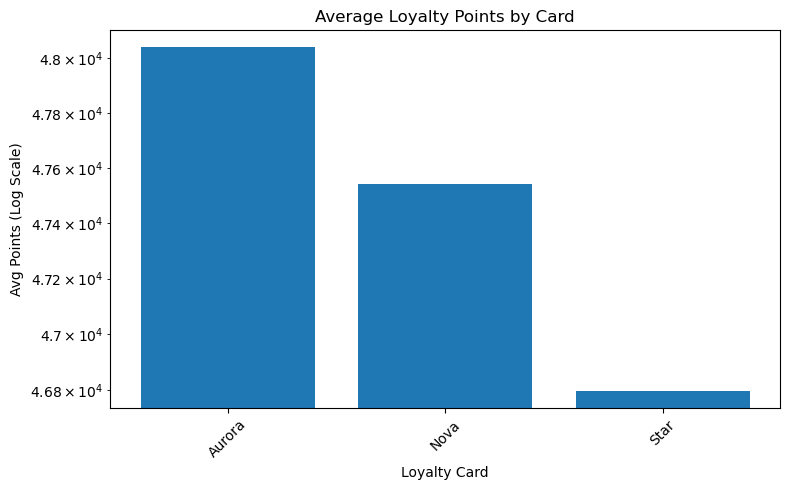

In [13]:
# For visualization, while the data query result is not big, therefore convert it to df
loyalty_card_point_dist_pd = (loyalty_card_point_dist.toPandas())
visual_result_path = 'visual_result_image'
# Create folder with name choosen as path
os.makedirs(visual_result_path, exist_ok=True)
df = loyalty_card_point_dist_pd
# Filter out loyalty cards with zero or negative average points to avoid issues with log scale
df = df[df['average_total_loyalty_points'] > 0]
plt.figure(figsize=(8, 5))
# Plot a bar chart using matplotlib with a logarithmic y-axis due to the wide range of values
plt.bar(df['loyalty_card'], df['average_total_loyalty_points'])
plt.title("Average Loyalty Points by Card")
plt.yscale("log") # Use logarithmic scale for y-axis to better visualize small and large values
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.xlabel("Loyalty Card")
plt.ylabel("Avg Points (Log Scale)")
plt.tight_layout() # Adjust layout to prevent clipping of labels

# Save the plot as a PNG image in the specified folder
plt.savefig(f"{visual_result_path}/img_loyalty_card_point_dist.png")
plt.show()
plt.close()

In [14]:
# Create path for joined table.
join_result_path = 'join_table_result_file'
#Create the folder.
os.makedirs(join_result_path,exist_ok=True)
#Convert the joined table to CSV format.
merged_df1.write.csv(f"{join_result_path}/merged_df1.csv", header=True, mode='overwrite')

# Create path for query result table.
query_result_path = 'query_table_result_file'
# Create folder for query result table.
os.makedirs(query_result_path, exist_ok=True)
# convert the query table to CSV format.
loyalty_card_point_dist_pd.to_csv(f"{query_result_path}/loyalty_card_point_dist.csv", header=True, index = False)




In [15]:
# 3.Is there any corelation between the education level with the total flights already take by customer?
# from the joined table before, calculate the average total_flights_taken group by education.
education_to_total_flights = spark.sql(
    """
    SELECT education, CAST(AVG(total_flights_taken) AS DECIMAL(10,3)) as average_total_flights_taken
    FROM join_table1
    GROUP BY education
    ORDER BY average_total_flights_taken DESC
    """
)
education_to_total_flights.show()

+--------------------+---------------------------+
|           education|average_total_flights_taken|
+--------------------+---------------------------+
|High School or Below|                     30.789|
|              Master|                     30.610|
|             College|                     30.492|
|              Doctor|                     30.253|
|            Bachelor|                     30.123|
+--------------------+---------------------------+



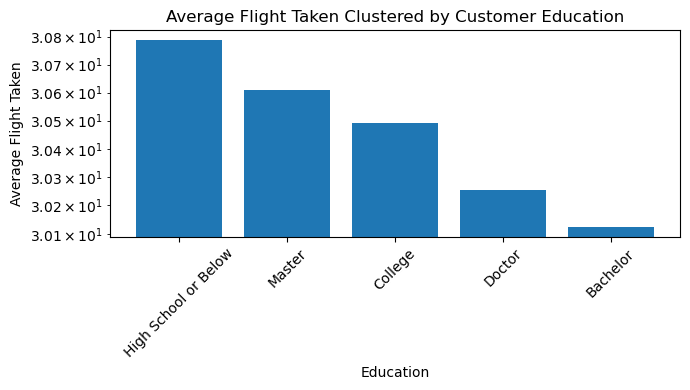

In [16]:
education_to_total_flights_pd = (education_to_total_flights.toPandas())

df = education_to_total_flights_pd
df = df[df['average_total_flights_taken']>0]
plt.figure(figsize=(7, 4))
plt.bar(df['education'], df['average_total_flights_taken'])
plt.title("Average Flight Taken Clustered by Customer Education")
plt.yscale("log")
plt.xticks(rotation=45)
plt.xlabel("Education")
plt.ylabel("Average Flight Taken (Log Scale)")
plt.ylabel("Average Flight Taken")
plt.tight_layout()
plt.savefig(f"{visual_result_path}/img_average_total_flights_taken.png")
plt.show()
plt.close()

In [17]:

education_to_total_flights_pd.to_csv(f"{query_result_path}/education_to_total_flights.csv", header=True, index = False)

In [18]:
# 4.How's the trend of total flights in Months?

# For joined the table customer_activity_df with calendar, convert the date to be format date-month.
# This column will have the format "MM-YYYY" (e.g., "02-2025") to enable joining on months and years.

# Add "month_year" column to customer_activity_df by combining month and year columns, zero-padding month to 2 digits.
customer_activity_df = customer_activity_df.withColumn(
    "month_year",
    concat(
        lpad(col("month").cast("string"),2,"0"),
        lit("-"),
        col("year").cast("string")
        )
).drop("_c0")  # Drop the unwanted column if present

# Add "month_year" column to calendar_df by extracting month and year from the "date" column, zero-padding month
calendar_df = calendar_df.withColumn(
    "month_year",
    concat(
        lpad(month(col("date")).cast("string"),2,"0"),
        lit("-"),
        year(col("date")).cast("string")
        )
).drop("_c0").drop("date") # Drop unnecessary columns after transformation.
calendar_df = calendar_df.dropDuplicates()# Remove any duplicate rows.

# Perform a left join on "month_year" to combine customer activity with calendar information
merged_df2 = (
    customer_activity_df
    .select("loyalty_number","year","month","month_year","total_flights","distance","points_accumulated","points_redeemed","dollar_cost_points_redeemed")
    .join(calendar_df,on = "month_year", how = "left")
)
merged_df2.show(50)




+----------+--------------+----+-----+-------------+--------+------------------+---------------+---------------------------+-----------------+--------------------+------------------+
|month_year|loyalty_number|year|month|total_flights|distance|points_accumulated|points_redeemed|dollar_cost_points_redeemed|start_of_the_year|start_of_the_quarter|start_of_the_month|
+----------+--------------+----+-----+-------------+--------+------------------+---------------+---------------------------+-----------------+--------------------+------------------+
|   05-2018|        135134|2018|    5|            4|    3252|            4878.0|              0|                          0|       2018-01-01|          2018-04-01|        2018-05-01|
|   05-2018|        150383|2018|    5|            0|       0|               0.0|              0|                          0|       2018-01-01|          2018-04-01|        2018-05-01|
|   05-2018|        152016|2018|    5|            8|   13024|           19536.0|     

In [19]:
# To obtained the total flight each months, convert the month at start_of_the_month to text for readable result later.
# calculate the total flights and and group and order it by start_of_the_month start_of_the_month.
(merged_df2.createOrReplaceTempView("join_table2"))
flights_trend = spark.sql(
    """
    SELECT date_format(start_of_the_month,'MMMM-yy') AS month_label, SUM(total_flights) as total_flights_taken
    FROM join_table2
    GROUP BY start_of_the_month
    ORDER BY start_of_the_month ASC
    """

)
flights_trend.show()

+------------+-------------------+
| month_label|total_flights_taken|
+------------+-------------------+
|  January-17|            13059.0|
| February-17|            13368.0|
|    March-17|            18391.0|
|    April-17|            15449.0|
|      May-17|            18690.0|
|     June-17|            23504.0|
|     July-17|            26312.0|
|   August-17|            22976.0|
|September-17|            17439.0|
|  October-17|            16458.0|
| November-17|            15745.0|
| December-17|            21871.0|
|  January-18|            13325.0|
| February-18|            13429.0|
|    March-18|            19476.0|
|    April-18|            15522.0|
|      May-18|            27345.0|
|     June-18|            33840.0|
|     July-18|            37936.0|
|   August-18|            32808.0|
+------------+-------------------+
only showing top 20 rows



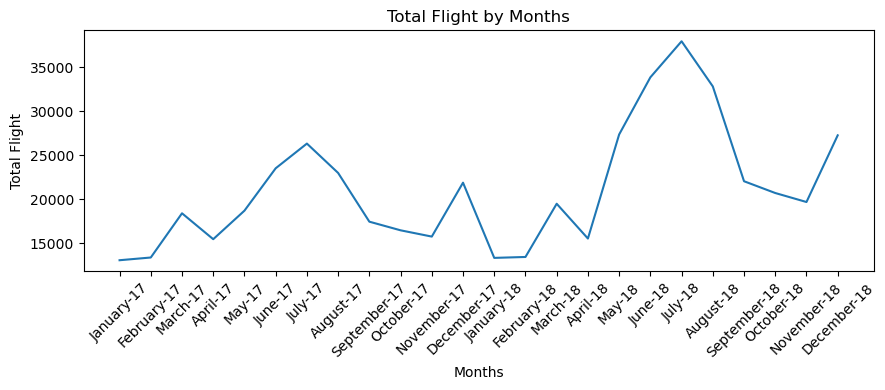

In [20]:
flights_trend_pd = (flights_trend.toPandas())

df = flights_trend_pd
df = df[df["total_flights_taken"]>0]
plt.figure(figsize=(9, 4))
plt.plot(df['month_label'], df['total_flights_taken'])
plt.title("Total Flight by Months")
plt.xlabel("Months")
plt.ylabel("Total Flight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{visual_result_path}/img_total_flights_taken_by_months.png")
plt.show()
plt.close()



In [21]:
merged_df2.write.csv(f"{join_result_path}/merged_df2.csv", header=True, mode='overwrite')
flights_trend_pd.to_csv(f"{query_result_path}/flights_trend.csv", header=True, index = False)

In [22]:
# Additional report :
# Order the country regarding to total flight!
# Please check the gender percentage!
# How the trend of flights by quartal?

In [23]:
customer_total_each_city  = spark.sql("""
SELECT city, COUNT(city) as total_customer from join_table1
GROUP BY city
ORDER BY total_customer DESC
""")
customer_total_each_city.show()

+--------------+--------------+
|          city|total_customer|
+--------------+--------------+
|       Toronto|          3351|
|     Vancouver|          2582|
|      Montreal|          2059|
|      Winnipeg|           658|
|      Whistler|           582|
|       Halifax|           518|
|        Ottawa|           509|
|      Edmonton|           486|
|       Trenton|           486|
|   Quebec City|           485|
|  Dawson Creek|           444|
|   Fredericton|           425|
|        Regina|           409|
|      Kingston|           401|
|     Tremblant|           398|
|      Victoria|           389|
|          Hull|           358|
|West Vancouver|           324|
|    St. John's|           258|
|   Thunder Bay|           256|
+--------------+--------------+
only showing top 20 rows



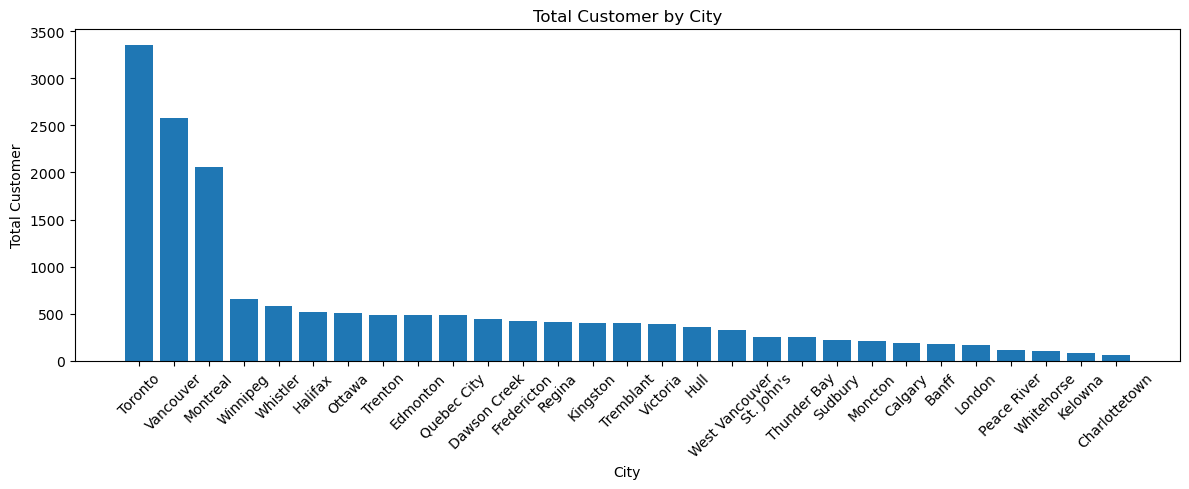

In [24]:
customer_total_each_city_df = (customer_total_each_city.toPandas())
df=  customer_total_each_city_df
df = df[df["total_customer"]>0]
plt.figure(figsize=(12, 5))
plt.bar(df["city"], df["total_customer"])
plt.title("Total Customer by City")
plt.xlabel("City")
plt.ylabel("Total Customer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{visual_result_path}/img_customer_total_each_city.png")
plt.show()
plt.close()

In [25]:
flights_trend_pd.to_csv(f"{query_result_path}/customer_total_each_city.csv", header=True, index = False)

+------+-----+
|gender|count|
+------+-----+
|Female| 8410|
|  Male| 8327|
+------+-----+



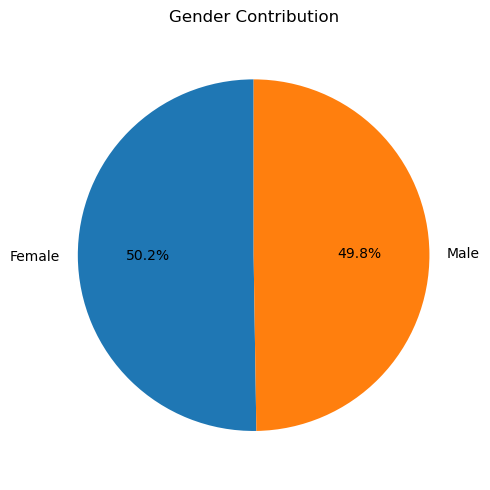

In [26]:
find_gender = spark.sql(
    """
    SELECT gender, COUNT(*) as count from join_table1
    GROUP BY gender
    """
)
find_gender.show()
find_gender_pd = find_gender.toPandas()


plt.figure(figsize=(5, 5))
plt.pie(find_gender_pd['count'], labels=find_gender_pd['gender'], autopct='%1.1f%%', startangle=90)
plt.title("Gender Contribution")
plt.axis('equal')
plt.tight_layout()
plt.savefig(f"{visual_result_path}/img_gender_distribution_pie.png")
plt.show()
plt.close()


In [27]:
#Trend by Quarter
flight_by_quarter = spark.sql(
    """
    SELECT 
        CONCAT('Q', QUARTER(start_of_the_quarter), '-', YEAR(start_of_the_quarter)) AS quarter_label,
        SUM(total_flights) AS total_flights_taken
    FROM join_table2
    GROUP BY start_of_the_quarter
    ORDER BY start_of_the_quarter ASC
    """
)
flight_by_quarter.show()

#Trend by Year
flight_by_year = spark.sql(
    """
    SELECT 
        year,
        SUM(total_flights) AS total_flights_taken
    FROM join_table2
    GROUP BY year
    ORDER BY year ASC
    """
)
flight_by_year.show()


+-------------+-------------------+
|quarter_label|total_flights_taken|
+-------------+-------------------+
|      Q1-2017|            44818.0|
|      Q2-2017|            57643.0|
|      Q3-2017|            66727.0|
|      Q4-2017|            54074.0|
|      Q1-2018|            46230.0|
|      Q2-2018|            76707.0|
|      Q3-2018|            92778.0|
|      Q4-2018|            67618.0|
+-------------+-------------------+

+----+-------------------+
|year|total_flights_taken|
+----+-------------------+
|2017|           223262.0|
|2018|           283333.0|
+----+-------------------+



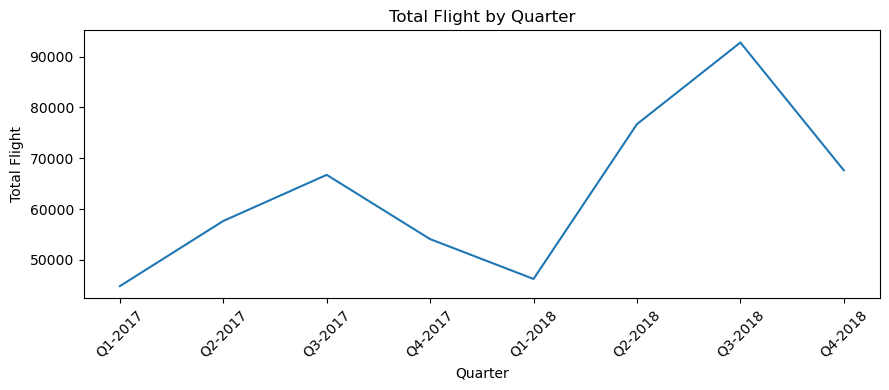

In [28]:
flight_by_quarter_df = (flight_by_quarter.toPandas())
df = flight_by_quarter_df
df = df[df["total_flights_taken"]>0]
plt.figure(figsize=(9, 4))
plt.plot(df['quarter_label'], df['total_flights_taken'])
plt.title("Total Flight by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Flight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{visual_result_path}/img_total_flights_taken_by_quarter.png")
plt.show()
plt.close()

In [29]:
flights_trend_pd.to_csv(f"{query_result_path}/total_flights_taken_by_quarter.csv", header=True, index = False)